# Eigenfaces

The technique of eigenfaces is an application of PCA to human facial images. Identification and recognition of human faces is easy for us because we are hardwired to do so, but it is not as straightforward for a machine to replicate these tasks. In addition to different faces having different appearances, images can also vary in quality, lighting, viewpoint, etc. So one approach is to try to extract a small set of "basis faces" from a set of facial images. These represent the basic ingredients of human faces and can be used to analyze future faces and images.

This tutorial is based on the one from SciPy Lectures on eigenfaces, accessible here: https://scipy-lectures.org/packages/scikit-learn/auto_examples/plot_eigenfaces.html. The dataset is imported from the scikit-learn library. The first 15 images are displayed below.

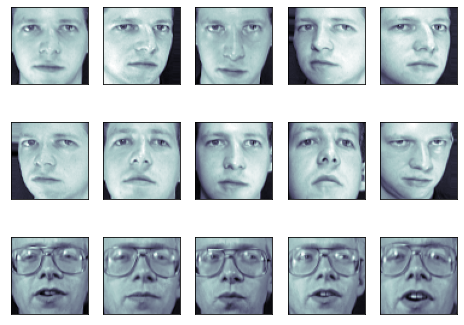

In [1]:
from matplotlib import pyplot as plt
import numpy as np
import pickle

faces = pickle.load(open("faces.json", 'rb'))

# display first 15 images
fig = plt.figure(figsize=(8, 6))
for i in range(15):
  ax = fig.add_subplot(3, 5, i + 1, xticks=[], yticks=[])
  ax.imshow(faces.images[i], cmap=plt.cm.bone)

In [4]:
faces.images.shape

(400, 64, 64)

The first step of PCA is to demean the data. So we form the $n \times p = 400 \times 4096$ data matrix $X$ and compute the "mean face". Each row represents a single image, whose 4096 pixels are reshaped into a row vector. Values indicate the brightness of each pixel.

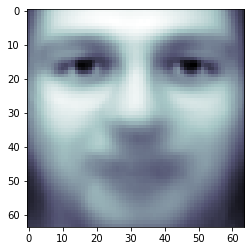

In [3]:
n = faces.images.shape[0]
p = faces.images[0].size
imsize = (faces.images.shape[1], faces.images.shape[2])
X = np.empty((n,p))

# form nxp data matrix, with each image as a row vector
for i in range(n):
  X[i,:] = np.reshape(faces.images[i], p)

# compute and display mean image
mean = np.mean(X, axis=0)
plt.imshow(np.reshape(mean, imsize), cmap=plt.cm.bone)
plt.show()

Note that $p$ is much larger than $n$. This is an instance of PCA where it is advantageous to work with the SVD of $X$ rather than computing the much larger covariance matrix.

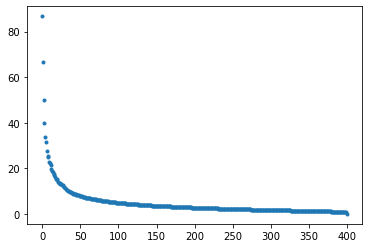

In [4]:
# compute SVD and show singular values
X -= mean
U, s, VT = np.linalg.svd(X)
plt.plot(s, '.')
plt.show()

From our scree plot of the singular values (proportional to the square roots of the variances), we see that most of them are relatively small compared to the first 50 or so values. This suggests that can possibly get away with using around this number of "eigenfaces" to represent images in the original dataset, and potentially other images as well.

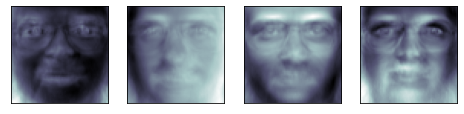

In [7]:
# show the first four eigenfaces
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(1, 4, 1, xticks=[], yticks=[])
ax.imshow(np.reshape(VT[0,:], imsize), cmap=plt.cm.bone)
ax = fig.add_subplot(1, 4, 2, xticks=[], yticks=[])
ax.imshow(np.reshape(VT[1,:], imsize), cmap=plt.cm.bone)
ax = fig.add_subplot(1, 4, 3, xticks=[], yticks=[])
ax.imshow(np.reshape(VT[2,:], imsize), cmap=plt.cm.bone)
ax = fig.add_subplot(1, 4, 4, xticks=[], yticks=[])
ax.imshow(np.reshape(VT[3,:], imsize), cmap=plt.cm.bone)
plt.show()

We can actually plot out the first few eigenfaces to understand what they look like. While a bit disturbing to look at, these images do show us some features that may be common across many images. In the first one we see some shadows of eyes, a nose, and mouth, along with the outline of the face in the two lower corners. The second one shows a contrast between the left and right sides, capturing a one-sided lighting source.

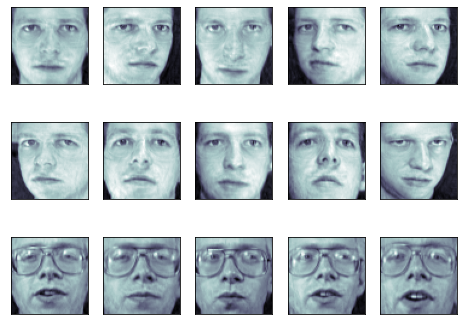

In [10]:
# coordinates of X in first k PCs -> nxk matrix
k = 200
T = X @ VT.T[:,:k]

# plot the rank-k approximations of original images
# remember to add mean image back before plotting
fig = plt.figure(figsize=(8, 6))
for i in range(15):
  ax = fig.add_subplot(3, 5, i + 1, xticks=[], yticks=[])
  rank_k_image = T[i,:] @ VT[:k,:]
  ax.imshow(np.reshape(rank_k_image + mean, imsize), cmap=plt.cm.bone)

Finally, we can project the original images onto a subset of the PCs and visualize the results. This is like doing image compression for a single image, but instead of computing and then keeping the components corresponding to a single image, we "compress" each image by using the same PCs computed from the entire dataset. The resultant data matrix will then have reduced rank.

We start by computing the scores matrix $T_k = XV_k = U \Sigma_k$. This is a $n \times k$ matrix where each row corresponds to the same image and row in $X$, and each column contains the coordinates of each image in the corresponding PC.

With these scores, we can then reconstruct the images in the "standard" basis by computing $T_k V_k^\top$; this is equivalent to computing a linear combination of the *rows* of $V_k^\top$ (the PCs), weighted by the corresponding scores. Note that the result is again a $n \times p$ (original size of $X$), but the rank is reduced to $k$.

Lastly, for looking at images it is important to add the mean image. The PC directions are not changed, but we are better able to see the details of the images.